In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')
import spacy
nlp = spacy.load("en_core_web_sm")
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize , sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df_Fake = pd.read_csv('/content/Fake.csv')
df_Fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [ ]:
df_True = pd.read_csv('/content/True.csv')
df_True

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [ ]:
def check_balance(df, label_col):
    label_counts = df[label_col].value_counts()  # Đếm số mẫu mỗi nhãn
    label_percent = df[label_col].value_counts(normalize=True) * 100  # Tỉ lệ %
    majority = label_counts.max()  # Lớp chiếm đa số
    minority = label_counts.min()  # Lớp chiếm thiểu số

    # Chỉ số mất cân bằng (Imbalance Ratio)
    IR = majority / minority

    # Xác suất p_i của mỗi nhãn
    p = label_percent / 100

    # Entropy đo độ hỗn loạn của phân phối nhãn (cao -> cân bằng)
    import numpy as np
    entropy = -np.sum(p * np.log2(p))

    print(f"Count:\n{label_counts}\n")
    print(f"Percent (%):\n{label_percent.round(2)}\n")
    print(f"Imbalance Ratio (IR): {IR:.2f}")
    print(f"Entropy: {entropy:.3f}")


In [ ]:
import pandas as pd

df_Fake = pd.read_csv('/content/Fake.csv')
df_True = pd.read_csv('/content/True.csv')

df_Fake['label'] = 'Fake'
df_True['label'] = 'True'

df_all = pd.concat([df_Fake, df_True], ignore_index=True)

check_balance(df_all, 'label')


Count:
label
Fake    23481
True    21417
Name: count, dtype: int64

Percent (%):
label
Fake    52.3
True    47.7
Name: proportion, dtype: float64

Imbalance Ratio (IR): 1.10
Entropy: 0.998


In [ ]:
df_Fake.isna().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [ ]:
# Check NaN Value in True News Data
df_True.isna().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [ ]:
# Show Describe of Fake News Data
pd.DataFrame({'Count':df_Fake.shape[0],
              'Null':df_Fake.isnull().sum(),
              'Null %':df_Fake.isnull().mean() * 100,
              'Cardinality':df_Fake.nunique()
})

,Count,Null,Null %,Cardinality
title,23481,0,0.0,17903
text,23481,0,0.0,17455
subject,23481,0,0.0,6
date,23481,0,0.0,1681
label,23481,0,0.0,1


In [ ]:
# Show Describe of True News Data
pd.DataFrame({'Count':df_True.shape[0],
              'Null':df_True.isnull().sum(),
              'Null %':df_True.isnull().mean() * 100,
              'Cardinality':df_True.nunique()
})

,Count,Null,Null %,Cardinality
title,21417,0,0.0,20826
text,21417,0,0.0,21192
subject,21417,0,0.0,2
date,21417,0,0.0,716
label,21417,0,0.0,1


In [ ]:
# Check Dublication in Fake News Data
df_Fake.duplicated().sum()

np.int64(3)

In [ ]:
# Check Dublication in True News Data
df_True.duplicated().sum()

np.int64(206)

In [ ]:
# Drop Dublication in Fake and True News Data
df_Fake.drop_duplicates(inplace=True)
df_True.drop_duplicates(inplace=True)

In [ ]:
# Combine Fake and True News Data
df_Fake['label'] = 'Fake'
df_True['label'] = 'True'
df = pd.concat([df_Fake,df_True],axis=0).reset_index(drop=True)

# Combine Title and Text to one Column
df['Content'] = df['title'] + ' ' + df['text']

In [ ]:
# Check Dublication in Combined Data (Content Column)
df[['Content']].duplicated().sum()

np.int64(5584)

In [ ]:
# Drop Dublication in Combined Data (Content Column)
df = df.drop_duplicates(subset=['Content'], keep='first')

In [ ]:
# Show Shape of Combined Data
print(f"Number of Row : {df.shape[0]}\nNumber of Columns : {df.shape[1]}")

Number of Row : 39105
Number of Columns : 6


In [ ]:
# Feature Engineering
df['No_of_Characters'] = df['Content'].apply(len)
import nltk
nltk.download('punkt_tab')
df['No_of_Words'] = df['Content'].apply(lambda x:len(word_tokenize(x)))
df['No_of_Sentences'] = df['Content'].apply(lambda x:len(sent_tokenize(x)))
df.describe()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,No_of_Characters,No_of_Words,No_of_Sentences
count,39105.000000,39105.000000,39105.000000
mean,2505.880629,460.775016,14.989797
std,1943.950515,357.262285,12.011661
min,31.000000,5.000000,1.000000
25%,1348.000000,246.000000,7.000000
50%,2288.000000,422.000000,13.000000
75%,3163.000000,583.000000,20.000000
max,51893.000000,9970.000000,321.000000


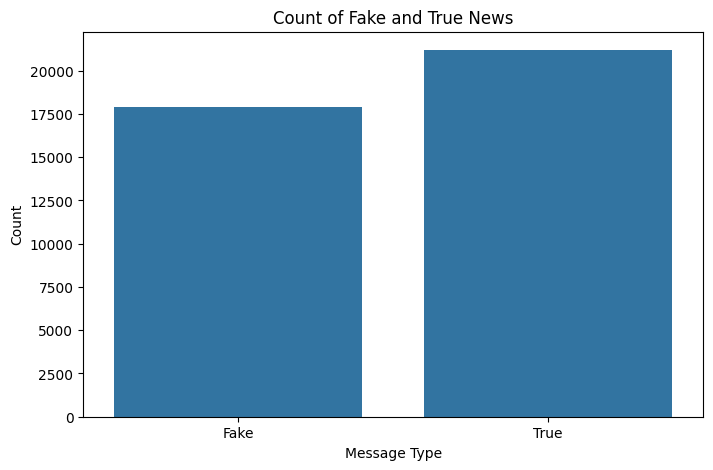

In [ ]:
# plot the count of spam and ham messages
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df)
plt.title('Count of Fake and True News')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

Count:
label
True    21197
Fake    17908
Name: count, dtype: int64

Percent (%):
label
True    54.21
Fake    45.79
Name: proportion, dtype: float64

Imbalance Ratio (IR): 1.18
Entropy: 0.995


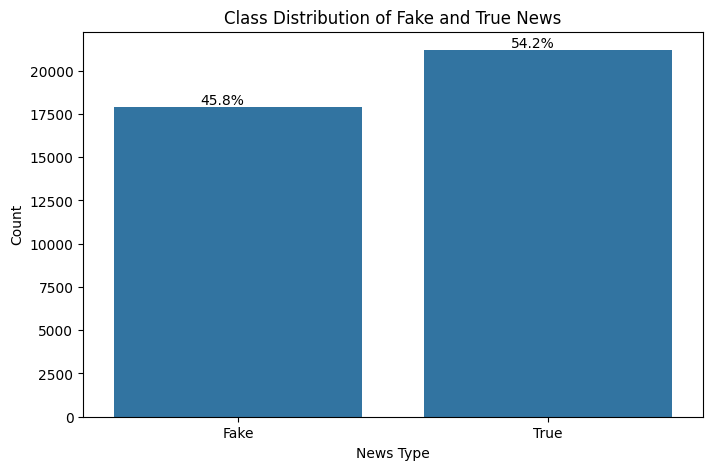

In [ ]:
# Check class distribution of the combined data
check_balance(df, 'label')

# Visualize the class distribution with percentages
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=df)
plt.title('Class Distribution of Fake and True News')
plt.xlabel('News Type')
plt.ylabel('Count')

# Add percentages on top of the bars
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

In [ ]:
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# --- chuẩn bị sẵn ---
try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
except OSError:
    print("Downloading spaCy model...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

import nltk
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))


def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(tokens)

# --- bước 1: làm sạch cơ bản trước ---
df["cleaned_text"] = df["Content"].apply(lambda x: clean_text(x.lower()))

# --- bước 2: lemmatization bằng spaCy theo batch ---
texts = df["cleaned_text"].tolist()
lemmas = []

for doc in nlp.pipe(texts, batch_size=100, n_process=4):  # chạy song song
    lemmas.append(" ".join([token.lemma_ for token in doc if token.lemma_ != '-PRON-']))

df["cleaned_text"] = lemmas

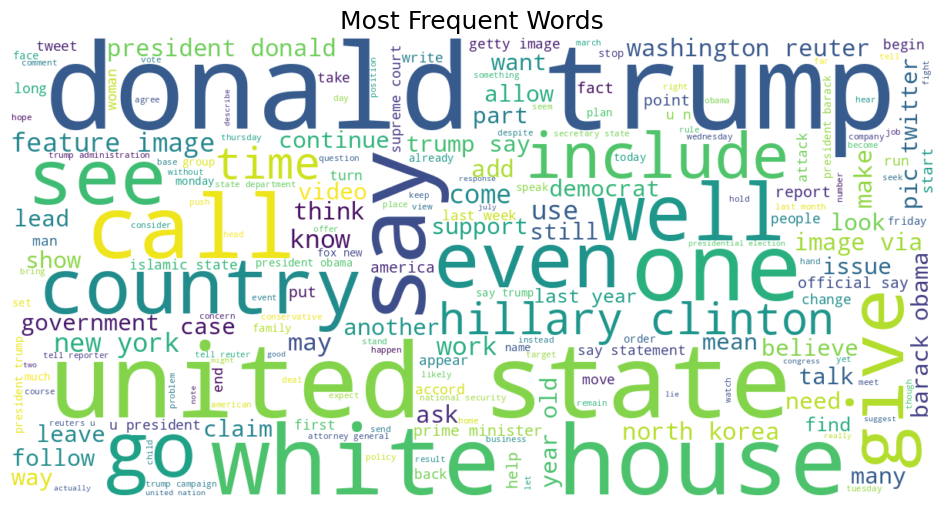

In [ ]:
# Generate a WordCloud from cleaned text
all_text = ' '.join(df['cleaned_text'])

wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words", fontsize=18)
plt.show()

In [ ]:
# Encode Categorical Columns
df['label'] = df['label'].map({'Fake':0,'True':1})
df.head()

,title,text,subject,date,label,Content,No_of_Characters,No_of_Words,No_of_Sentences,cleaned_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...,2973,614,28,donald trump send embarrass new year eve messa...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...,1968,339,11,drunk bragging trump staffer start russian col...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...,3688,706,25,sheriff david clarke become internet joke thre...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...,2853,537,15,trump obsess even obama name code website imag...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...,2417,469,19,pope francis call donald trump christmas speec...


In [ ]:
# Split Data
X = df[['cleaned_text']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('X_train Shape :',X_train.shape)
print('X_test Shape :',X_test.shape)
print('y_train Shape :',y_train.shape)
print('y_test Shape :',y_test.shape)

X_train Shape : (31284, 1)
X_test Shape : (7821, 1)
y_train Shape : (31284,)
y_test Shape : (7821,)


In [ ]:
# Step 1: TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_text'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_text'])

In [ ]:
def train(model ,model_name ,X_train ,y_train ,X_test ,y_test):
    model.fit(X_train,y_train)
    model_train_score = model.score(X_train,y_train)
    model_test_score = model.score(X_test,y_test)
    print(f"{model_name} model score on Training data: {model_train_score * 100}%\n{model_name} model score on Testing data: {model_test_score * 100}%")

def class_report(model ,X_test , y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['Fake', 'True']))

In [ ]:
lr = LogisticRegression()
train(lr,"Logistic Regression", X_train_tfidf, y_train, X_test_tfidf, y_test)
class_report(lr, X_test_tfidf, y_test)

Logistic Regression model score on Training data: 99.05702595576014%
Logistic Regression model score on Testing data: 98.60631632783532%
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98      3582
        True       0.98      0.99      0.99      4239

    accuracy                           0.99      7821
   macro avg       0.99      0.99      0.99      7821
weighted avg       0.99      0.99      0.99      7821



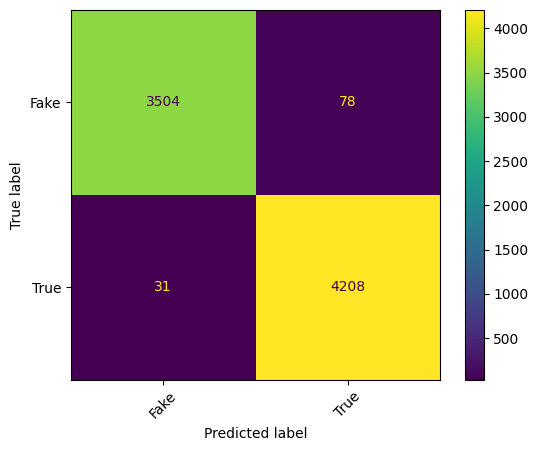

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr,
                                       X_test_tfidf,
                                       y_test,
                                       xticks_rotation=45,
                                       display_labels=['Fake', 'True'])

In [ ]:
xgboost = model = XGBClassifier(objective = "binary:logistic" , subsample = 0.7 , min_child_weight = 3,
                                max_depth = 3 , learning_rate = 0.1 , gamma = 0 , colsample_bytree = 0.5,)
train(xgboost,"Xgboost", X_train_tfidf, y_train, X_test_tfidf, y_test)
class_report(xgboost, X_test_tfidf, y_test)

Xgboost model score on Training data: 99.76985040276179%
Xgboost model score on Testing data: 99.64198951540723%
              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      3582
        True       0.99      1.00      1.00      4239

    accuracy                           1.00      7821
   macro avg       1.00      1.00      1.00      7821
weighted avg       1.00      1.00      1.00      7821



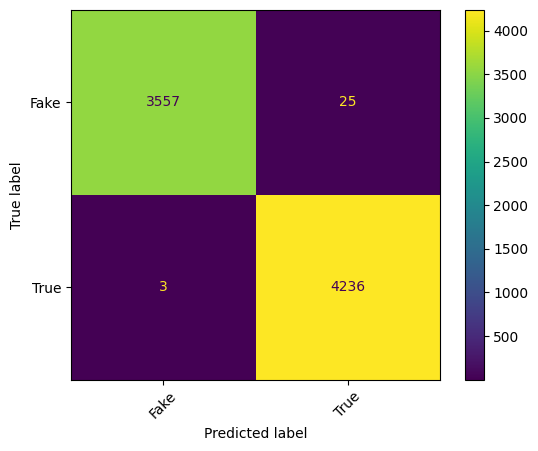

In [ ]:
ConfusionMatrixDisplay.from_estimator(xgboost,
                                       X_test_tfidf,
                                       y_test,
                                       xticks_rotation=45,
                                       display_labels=['Fake', 'True']
    );

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
train(rf, "Random Forest", X_train_tfidf, y_train, X_test_tfidf, y_test)
class_report(rf, X_test_tfidf, y_test)

Random Forest model score on Training data: 100.0%
Random Forest model score on Testing data: 98.14601713335891%
              precision    recall  f1-score   support

        Fake       0.99      0.97      0.98      3582
        True       0.97      0.99      0.98      4239

    accuracy                           0.98      7821
   macro avg       0.98      0.98      0.98      7821
weighted avg       0.98      0.98      0.98      7821



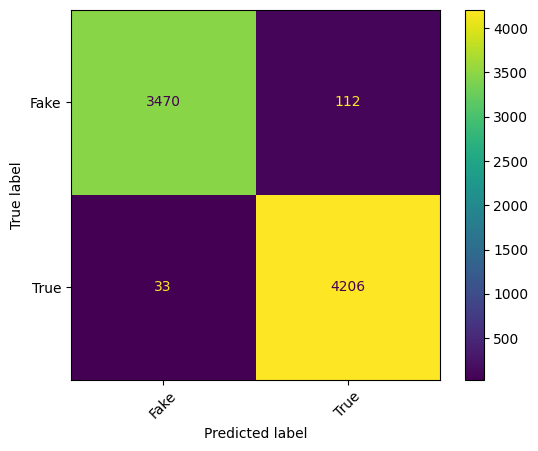

In [ ]:
ConfusionMatrixDisplay.from_estimator(rf,
                                       X_test_tfidf,
                                       y_test,
                                       xticks_rotation=45,
                                       display_labels=['Fake', 'True']
    );

Naive Bayes model score on Training data: 94.52435749904105%
Naive Bayes model score on Testing data: 93.99053829433576%
              precision    recall  f1-score   support

        Fake       0.96      0.91      0.93      3582
        True       0.93      0.97      0.95      4239

    accuracy                           0.94      7821
   macro avg       0.94      0.94      0.94      7821
weighted avg       0.94      0.94      0.94      7821



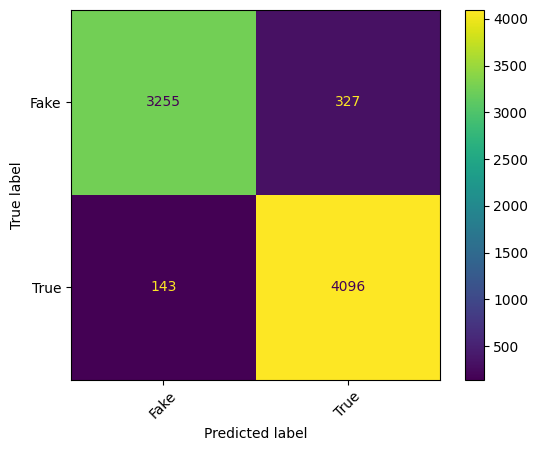

In [ ]:
ConfusionMatrixDisplay.from_estimator(nb,
                                       X_test_tfidf,
                                       y_test,
                                       xticks_rotation=45,
                                       display_labels=['Fake', 'True']
    );